<center>
    
## Aprendizaje No Supervisado - DiploDatos
    Laura Alonso Alemany y Valeria Rulloni
## Embeddings y Agrupamiento con el FIFA 2019 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [2]:
from sklearn import (manifold, preprocessing, decomposition)
import time

In [3]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de Kaggle.


https://www.kaggle.com/datasets/stefanoleone992/fifa-23-complete-player-dataset

In [4]:
url='https://raw.githubusercontent.com/DiploDatos/AprendizajeNOSupervisado/master/2021/data.csv'


In [5]:
df=pd.read_csv(url)

# 3.-Visualizacion-con-embeddings:tSNE

**t-SNE : t-distributed Stochastic Neighbor Embedding.**

t-SNE es una herramienta para visualizar datos altamente dimensionales.

Los "proyecta" en menos dimensiones (2D o 3D) manteniendo la distancia entre ellos.

Consideramos: filas/observaciones $x_i$ y $x_j$ (jugador i y jugador j) en $R^n$.

Comienza convirtiendo distancias entre puntos (observaciones) en probabilidades condicionales.

$d(x_i,x_j) \rightarrow p(x_j|x_i)$,

Y luego va acomodando puntos asociados (en el plano 2D o el espacio 2D) que "ajusten" las probabilidades condicionales.

$x'_i$ y $x'_j$ en $R^2$  (para el jugador i y jugador j ) $p(x'_j|x'_i) \leftrightarrow d(x'_i,x'_j)$,

$p(x_j|x_i) \approx p(x'_j|x'_i)$

El ajuste consiste en minimizar la divergencia Kullback-Leibler entre las probabilidades condicionales establecidas en el espacio de mayor dimension y las determinadas en el espacio de menor dimension.


El modelo de distribución de probabilidad es el de t-Student

t-SNE tiene una función de costo que no es convexa, por lo cual diferentes inicializaciones pueden dar diferentes resultados.


In [ ]:
n_sne=1000 #elegir numero pequeño para agilidad en el cálculo luego
df_sne=df.loc[:n_sne]
skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
                  'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
                  'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
                  'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
                  'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                  'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
                  'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
X=df_sne[skills_ratings]
print('dimensión del espacio de los datos: ', len(skills_ratings))

dimensión del espacio de los datos:  34


In [ ]:
X.head(5)

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


Transformamos el espacio de dim 34 en un espacio de dimensión 2 (n_components=2)

In [ ]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1001 samples in 0.001s...
[t-SNE] Computed neighbors for 1001 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1001
[t-SNE] Computed conditional probabilities for sample 1001 / 1001
[t-SNE] Mean sigma: 18.324976
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.225925
[t-SNE] KL divergence after 1000 iterations: 0.959465
t-SNE done! Time elapsed: 7.790987491607666 seconds


**El resultado (X_tsne) se guarda en una arreglo numpy**

de tamaño:

cantidad de filas = cantidad de jugadores considerados = n_tsne y

cantidad de columnas= n_components = 2

In [ ]:
print(X_tsne.shape)
print(X_tsne)
#X_tsne[1990:2000] #diez jugadores

(1001, 2)
[[ -7.0311775 -27.631233 ]
 [ -1.1031954 -22.244366 ]
 [ -7.0528545 -27.401423 ]
 ...
 [ -4.0833673  -9.12768  ]
 [ -8.307221   17.561697 ]
 [ -3.4413507   1.8826184]]


**GRAFICAMOS: Scatter plot**

Las variables que usamos para el scatterplot son las 2 componentes dadas por tSNE

agregamos los nombres de los ckack ("Overall" más de 85) y vemos una tercera variable recorriendo los puntos sobre el gráfico

In [ ]:
data=[]
bool_crack=df_sne["Overall"] > 85 #diferenciamos a los mejores jugadores

#graficamos los datos en el espacio transformado: las dos componentes tsne

graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                           mode='markers',
                        text=df_sne.loc[:,'Position'], #'Height', 'Weight', 'Club', 'Age', 'Name','Position'
                           marker=dict(
                                size=5)
                           )

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Los más mejores',
                      text=df_sne.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[graf1,crack]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=700)

fig = go.Figure(data=data, layout=layout)

#iplot(fig)
#plot(fig)

In [ ]:
#En Colab
fig.show(renderer="colab")

**INTERPRETACIÓN**

Un poco de análisis visual supervisado usando tsne

Ponemos a prueba la intuición o preconcepto de que los jugadores se agrupan en el espacio de las habilidades (transformado/reducido por tsne) según la posición...

Creamos una nueva columna con 4 categorias de posiciones:

In [ ]:
forwards=['RF', 'ST', 'LW', 'LF', 'RS', 'LS', 'RM', 'LM','RW']
midfielders=['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF']
defenders=['RCB','CB','LCB','LB','RB','RWB','LWB']
goalkeepers=['GK']

def pos2(position):
    if position in forwards:
        return 'Forward'

    elif position in midfielders:
        return 'Midfielder'

    elif position in defenders:
        return 'Defender'

    elif position in goalkeepers:
        return 'GK'

    else:
        return 'nan'

In [ ]:
df_sne["Position2"]=df_sne["Position"].apply(lambda x: pos2(x))

df_sne["Position2"].value_counts()

Forward       318
Midfielder    299
Defender      275
GK            109
Name: Position2, dtype: int64

**GRAFICAMOS**

Las variables que usamos para el scatterplot son las 2 componentes dadas por tSNE

diferenciamos usando vectores booleanos: para cada posición y si es un ckack

In [ ]:
bool_striker= df_sne["Position2"] == 'Forward'
bool_midfielder= df_sne["Position2"] == 'Midfielder'
bool_defender= df_sne["Position2"] == 'Defender'
bool_gk= df_sne["Position2"] == 'GK'

bool_crack=df_sne["Overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']
data=[]

striker =go.Scatter(x=X_tsne[bool_striker,0], y=X_tsne[bool_striker,1],name='Striker',
                      text=df_sne.loc[bool_striker,'Name'],
                      opacity=0.9,marker=dict(color=palette[2],size=5),mode='markers')

midfielder =go.Scatter(x=X_tsne[bool_midfielder,0], y=X_tsne[bool_midfielder,1],name='Midfielder',
                      text=df_sne.loc[bool_midfielder,'Name'],
                      opacity=0.6,marker=dict(color=palette[1],size=5),mode='markers')

defender =go.Scatter(x=X_tsne[bool_defender,0], y=X_tsne[bool_defender,1],name='Defender',
                      text=df_sne.loc[bool_defender,'Name'],
                      opacity=0.7,marker=dict(color=palette[3],size=5),mode='markers')

gk =go.Scatter(x=X_tsne[bool_gk,0], y=X_tsne[bool_gk,1],name='GK',
                      text=df_sne.loc[bool_gk,'Name'],
                      opacity=0.4,marker=dict(color=palette[4],size=5),mode='markers')

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Top player',
                      text=df_sne.loc[bool_crack,'Name'],textfont=dict(family='sans serif',color='black',size=16),
                      opacity=0.9,mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players",titlefont=dict(size=20),
                autosize=False, width=1000,height=700)

fig = go.Figure(data=data, layout=layout)

#iplot(fig)
#plot(fig)

In [ ]:
#En Colab
fig.show(renderer="colab")

Como una primera observación, podemos ver que en este espacio 2D es realmente muy evidente la separación de los arqueros del resto de los jugadores (lo cual es lógico pues sus habilidades son muy diferentes, lo vimos también en la primera semana de clases en dimensión 34, graficando de a dos variable por vez).

El agrupamiento visual, en este espacio, de los jugadores no es tan evidente pues no se ven otros clusters disconexos.

Las posiciones no explican tan claramente las cercanías entre jugadores

Una explicación posible puede ser porque hay jugadores ambivalentes que unen los espacios entre defensa, mediocampo y ataque?

Habrá otra explicación??

Que otras variables (que no estamos graficando) pueden explicar los grupos?

En este espacio tsne ... es decir usando "X_tsne[:,0]" y "X_tsne[:,0]"

Cómo se verán en este espacio los grupos encontrados por kmedias o mean-shift?



# 4.-Componentes-Principales

PCA
Para reducción de dimensión
de n dimensiones a m dimensiones con 'm<<n'

Pseudo-ejemplo intuitivo:
Via láctea en 3D  https://youtu.be/WNASVRwdf9Q  o https://www.youtube.com/watch?v=S7GiZMVNB20                                        
a Via láctea en 2D (la proyección en 2D que mejor describe la dispersión de los datos/estrellas)

<center>


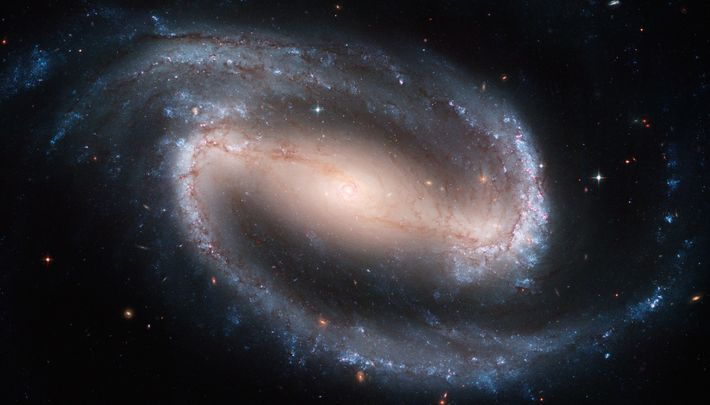

**Variables de desempeño (skills_ratings)**

**Retiramos arqueros y jugadores con bajo ranking**


In [7]:
n_acp=18000

df_acp=df.loc[:n_acp]
df_acp=df_acp[(df_acp["Position"]!='GK')&(df['Overall']>70)]

skills_ratings = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing',
                  'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing',
                  'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions',
                  'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
                  'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
                  'Marking', 'StandingTackle', 'SlidingTackle']

#OJO!! otros skills_ratings ! sacamos las habilidades asociadas a los arqueros

Restringimos los datos a las variables numéricas que consideramos

In [8]:
X=df_acp[skills_ratings] # Datos para proyectar
print('los datos tienen dimesión n= ',len(skills_ratings))

los datos tienen dimesión n=  29


**Se computan las componentes principales**

-cuando se usa *decomposition.PCA* :

La descomposición PCA del sklearn centra los datos pero no los escala (input data is centered but not scaled for each feature before applying the SVD)

por eso **estandarizamos/escalamos primero**

In [9]:
std_scale=preprocessing.StandardScaler().fit(X)
X_scaled=std_scale.transform(X) # numpyarray Estandarizado (le resta la media y divide por el desvío) por columna

In [10]:
print(X_scaled[0:2])
X.head(2)

[[ 1.55178383  2.24957304  0.52284861  2.76990328  1.92519949  2.48406149
   2.10464063  2.41719593  2.16894042  3.13436599  1.63853731  1.28605785
   1.68158232  4.15293158  2.07449554  1.4447627  -0.07468232 -0.08596743
  -0.95682489  2.1787789  -1.45782415 -1.83006237  2.03649449  2.35741033
   1.24387365  3.81754185 -1.31823168 -1.4572318  -1.35386641]
 [ 1.55178383  2.18935065  2.09652059  1.43080571  1.98829633  1.689769
   1.31383652  1.29568773  1.17712264  2.87288091  1.48291387  1.69068856
   1.36345808  4.33119417  0.17066511  2.34754321  2.19241365  1.52516918
   0.75628678  2.11192694 -0.33349395 -1.47484361  2.10232668  1.40429793
   2.01112381  3.66743589 -1.58542825 -1.31193411 -1.49415592]]


,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0


**DESCOMPOSICIÓN PCA**

En la descomposición podemos elegir n_components para quedarnos con una cantidad chica de componentes

la idea es que sean "bastante" menos que la dimensión de lo datos pero

que describan un buen porcentaje de la dispersión de los datos

In [11]:
pca=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más,

pca.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(X_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)


proporción de varianza por componente:  [0.41756081 0.15578282 0.10102352 0.06617818]
proporción de varianza por componente acumulada:  [0.41756081 0.57334363 0.67436716 0.74054534]
tamaño de los datos:  (4314, 4)


In [12]:
print (X_projected[0:5])#5 primeros jugadores, n_components

[[-9.71923271 -2.39287688  1.88993607 -1.06245178]
 [-7.7234215  -1.73309608  3.64860589 -4.70748044]
 [-8.78473979 -1.83202406  0.82020083 -1.29152906]
 [-6.70879924 -5.25138565  2.2255271  -0.79968708]
 [-8.49527264 -2.10938246  0.82702258 -1.0406278 ]]


In [13]:
pcs=pca.components_  #"composición" de las primeras componentes,
print(pcs)  # el aporte/pesos de las variables: skills_ratings

[[-0.20038315 -0.24233432  0.13996809 -0.15746377 -0.23335849 -0.25709369
  -0.23470358 -0.20528898 -0.07488701 -0.23952635 -0.17827746 -0.14741456
  -0.21933283 -0.09030436 -0.19110185 -0.18815454  0.05974576 -0.04879522
   0.16309839 -0.23758594  0.13914539  0.16590159 -0.2506906  -0.23260173
  -0.19843602 -0.10787446  0.16902477  0.17508709  0.17664088]
 [-0.1807997   0.10050461  0.01320353 -0.30928919  0.03893874 -0.06425316
  -0.10922851 -0.10908159 -0.36195183 -0.13794074  0.04595041  0.0652318
  -0.00876829 -0.21670983 -0.05492486 -0.04385088 -0.02034682 -0.20159336
  -0.01303987 -0.05338742 -0.22748079 -0.35158148  0.01852182 -0.15703721
   0.04042382 -0.19792732 -0.32608158 -0.3456168  -0.33540174]
 [-0.12797835  0.1716697   0.32288629  0.04559065  0.20316292 -0.05631801
   0.03281676  0.09887563 -0.00535164  0.03760716 -0.34103292 -0.31392183
  -0.28691192  0.16480213 -0.30051293  0.25036038  0.00387757 -0.15014875
   0.32113985  0.15939715  0.13138338 -0.05622993  0.09184517

OPCIONAL: El siguiente gráfico muestra la composición de los pesos de las dos primeras componentes principales.

In [14]:
#Graph 1
data=[]

for i, (x,y) in enumerate(zip(pcs[0,:],pcs[1,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=X.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=15))
    data.append(graph)

layout = go.Layout(title="ACP - Fifa Skills",titlefont=dict(size=20),
            xaxis=dict(title='Componente 1'),
            yaxis=dict(title='Componente 2'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data, layout=layout)
#plot(fig)

In [15]:
#En Colab
fig.show(renderer="colab")

Se crea el jugador perfecto para ver a donde se ubica en nuestra visualización, se lo agrega a los datos normalizados y a las componentes ya calculadas (sin usarlo pues modificaría los resultados y no corresponde utilizarlo, ya que es ficticio).

In [16]:
MachineGunDict={'Name':'MachineGun','Overall':99}
for skills in skills_ratings:
    MachineGunDict[skills]=99

#Lo agregamos a la base:
df_acp=df_acp.append(MachineGunDict,ignore_index=True)
X=df_acp[skills_ratings] # Datos sin estandarizar
X_scaled=std_scale.transform(X) # volvemos a estandarizar con el dato agregado
#pero con la estandarización de la base sin el dato nuevo
X_projected=pca.transform(X_scaled) # volvemos a proyectar pero con el dato nuevo

**Graficamos a los jugadores usando las dos primeras componentes de PCA, proyectamos los datos (de dim 29) en ese espacio de dimensión 2**

Identificamos a MachineGun y a un jugador en particular, por ejemplo, Lio Messi:

In [17]:
#Graph 2
#Choose your player
recherche_joueur=df_acp["Name"]=='L. Messi'

bool_crack=df_acp["Overall"] > 85
bool_no_crack=df_acp["Overall"]<86
bool_machinegun=df_acp["Name"]=='MachineGun'

palette=['navy','red','#A2D5F2','orange','green','pink']
data=[]

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Crack',
                      text=df_acp.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[2],size=7),mode='markers+text')

acp_no_crack =go.Scatter(x=X_projected[bool_no_crack,0], y=X_projected[bool_no_crack,1],name='Average player',
                         text=df_acp.loc[bool_no_crack,'Name'],
                         opacity=0.6,marker=dict(color=palette[1],size=3),mode='markers')

acp_machinegun =go.Scatter(x=X_projected[bool_machinegun,0], y=X_projected[bool_machinegun,1],name='Perfect player',
                           textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=0.6,marker=dict(color=palette[3],size=30),mode='markers+text')


joueur_recherche =go.Scatter(x=X_projected[recherche_joueur,0], y=X_projected[recherche_joueur,1],name='Searched player',
                           text=df_acp.loc[recherche_joueur,'Name'],
                            textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=1,marker=dict(color=palette[4],size=40),mode='markers+text')

data=[acp_no_crack,acp_crack,acp_machinegun,joueur_recherche]

layout = go.Layout(title="ACP - Fifa Players",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)

#plot(fig)

In [18]:
#En Colab
fig.show(renderer="colab")

Se puede comparar dos equipos y ver los perfiles de los jugadores en las dos primeras componentes.

In [ ]:
teamA='Liverpool'
teamB='Manchester United'

bool_teamA=df_acp["Club"]==teamA
bool_teamB=df_acp["Club"]==teamB

palette=['navy','red','#A2D5F2','orange','green','pink','grey']
data=[]

acp_teamA =go.Scatter(x=X_projected[bool_teamA,0], y=X_projected[bool_teamA,1],name=teamA,
                      text=df_acp.loc[bool_teamA,'Name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[1],size=10),mode='markers+text')

acp_teamB =go.Scatter(x=X_projected[bool_teamB,0], y=X_projected[bool_teamB,1],name=teamB,
                      text=df_acp.loc[bool_teamB,'Name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[4],size=10),mode='markers+text')

acp_all =go.Scatter(x=X_projected[:,0], y=X_projected[:,1],name='All',
                         text=df_acp.loc[:,'Name'],
                         opacity=0.3,marker=dict(color=palette[6],size=3),mode='markers')


data=[acp_teamA,acp_teamB,acp_all]

layout = go.Layout(title="ACP - {} vs {}".format(teamA,teamB),titlefont=dict(size=20),
                xaxis=dict(title='F1'),
                yaxis=dict(title='F2'),
                autosize=False, width=1000,height=750)

fig = go.Figure(data=data, layout=layout)
#plot(fig)

In [ ]:
#En Colab
fig.show(renderer="colab")

# 5 .-Clustering

**Trabajo en grupo**: Veamos ahora que agrupamientos podemos hacer de los jugadores usando las (dos/tres o) cuatro primeras componentes.

Presentar este ejercicio (con comentarios) pero con los datos del práctico entregable

In [ ]:
##Hay que quitar MachineGun para Clustering
df_acp=df.loc[:n_acp]
df_acp=df_acp[(df_acp["Position"]!='GK')&(df['Overall']>70)]

X=df_acp[skills_ratings] # Datos sin estandarizar
X_scaled=std_scale.transform(X) # volvemos a normalizar (ya estaba ajustada)
X_projected=pca.transform(X_scaled) #volvemos a proyectar
print('dimensiones de la base proyectada:', X_projected.shape)

dimensiones de la base proyectada: (4314, 4)


k-medias y visualizar los clusters encontrados en las dos primeras componentes

Mean Shift y visualizar en las dos primeras componentes

In [ ]:
#clusters2= ms.labels_

In [ ]:
data=[]
bool_crack=df_acp["Overall"] > 85
bool_no_crack=df_acp["Overall"]<86

kmean_clusters = go.Scatter(x=X_projected[:,0], y=X_projected[:,1],
                           mode='markers',
                        text=df_acp.loc[:,'Name'],
                           marker=dict(
                                size=5,
                                color = clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Top players',
                      text=df_acp.loc[bool_crack,'Name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters,acp_crack]

layout = go.Layout(title="ACP + Clustering Mean Shift ",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='Componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

plot(fig)

In [ ]:
#df_clusters=df_acp.copy()
#df_clusters['kmeans'] = km.labels_
#df_clusters['MeanShift'] = ms.labels_
#df_clusters.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,kmeans,MeanShift
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M,3,4
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M,4,14
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M,3,4
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M,4,4
5,5,183277,E. Hazard,27,https://cdn.sofifa.org/players/4/19/183277.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,91,Chelsea,https://cdn.sofifa.org/teams/2/light/5.png,€93M,€340K,2142,Right,4.0,4.0,4.0,High/ Medium,Normal,Yes,LF,10.0,"Jul 1, 2012",NaN,2020,5'8,163lbs,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,82+3,82+3,82+3,89+3,66+3,63+3,63+3,63+3,66+3,60+3,49+3,49+3,49+3,60+3,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,€172.1M,3,4
